# Biometrc Systems
## Face Morphing Attack Detection (MAD) 

####  Patrick Eidemüller 768465

### Table of Contents

* [1 Data Loading and Preperation ](#1)
    * [1.1 Load Packages ](#1.1)
    * [1.2 Create Dataset and Facecrop Class](#1.2)
    * [1.3 Transform Images](#1.3)
    * [1.4 Create Subset](#1.4)
    * [1.5 Create Data Loader](#1.5) 
    * [1.6 Print Data](#1.6)      
    
* [2 Self Trained CNN](#2) 
    * [2.1 Model Class - Architecture](#2.1)
    * [2.2 Train Model](#2.2)  
    * [2.3 Evaluate Model](#2.3)
    
* [3 Tranfer learning](#3)
    * [3.1 Load Model](#3.1)
    * [3.2 Freeze Weights](#3.2)
    * [3.3 Fine Tuning](#3.3)
    * [3.4 Train Transfer Learning Model](#3.4)
        * [3.4.1 Train, Validation & Test Accuracy](#3.4.1)
    * [3.5 Evaluate Transfer Learning Mode](#3.5)
        * [3.5.1 ROC Plot](#3.5.1)
        * [3.5.2 Test Accuracy](#3.5.2)
        * [3.5.3 Confusion Matrix and Performance Metrics](#3.5.3)
        * [3.5.4 DET Plot](#3.5.4)
    
* [4 Resume](#4)
    * [4.1 Resume](#4.1)
    * [4.1 Further Work](#4.1)
    
Click the Section to jump to the topic

### 1 Data Loading and Preperation <a class="anchor" id="1"></a>

#### 1.1 Load Packages <a class="anchor" id="1.1"></a> 

In [519]:
# import libraries 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.utils.data as data_utils
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import Subset
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torchvision.io import read_image
import seaborn as sns
from torchsummary import summary
import pandas as pd 
from PIL import Image
from pathlib import Path
import imagesize
from sklearn.utils import shuffle
import sklearn
from matplotlib import pyplot
from glob import glob
import cv2
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
cudnn.benchmark = True
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d

plt.ion()   # interactive mode

In [520]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [521]:
# get the path as a variable 

path = os.getcwd()
print(path)

/Users/patrickeidemuller/Documents/Uni/MasterDataScience/4_biometric/biometrics projekt


#### 1.2 Create Dataset and Facecrop Class  <a class="anchor" id="1.2"></a>

In [522]:
# # Klasse um das Dataset zu erstellen mit allen Pfaden 
# class FaceDataset(Dataset):
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.image_paths = self.get_image_paths()
#         #self.subset_ratio = subset_ratio  # Der Prozentsatz des Subsets (0.0-1.0)
        
#         # Haar Cascade Classifier initialisieren
#         self.face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


#     def get_image_paths(self):
#         # Hier können Sie die Bildpfade entsprechend Ihrer Ordnerstruktur festlegen
#         # Nehmen wir an, dass die Bonafide-Bilder im Unterordner "bonafide" und die Morph-Bilder im Unterordner "morphs" sind
    
#         bonafide_reference_path = os.path.join(self.root_dir, "./HDA_Morphing_DB_npp_subset/FERET", "bonafide_reference")
#         #bonafide_probe_path = os.path.join(self.root_dir, "./HDA_Morphing_DB_npp_subset/FERET", "bonafide_probe")
#         morphs_opencv_path = os.path.join(self.root_dir, "./HDA_Morphing_DB_npp_subset/FERET", "morphs_opencv")
#         #morphs_facefusion_path = os.path.join(self.root_dir, "./HDA_Morphing_DB_npp_subset/FERET", "morphs_facefusion")
#         #morphs_facemorpher_path = os.path.join(self.root_dir, "./HDA_Morphing_DB_npp_subset/FERET", "morphs_facemorpher")
#         #morphs_ubo_path = os.path.join(self.root_dir, "./HDA_Morphing_DB_npp_subset/FERET", "morphs_ubo")

        
#         bonafide_reference_images = [os.path.join(bonafide_reference_path, img) for img in os.listdir(bonafide_reference_path)]
#         #bonafide_probe_images = [os.path.join(bonafide_probe_path, img) for img in os.listdir(bonafide_probe_path)]
#         morphs_opencv_images = [os.path.join(morphs_opencv_path, img) for img in os.listdir(morphs_opencv_path)]
#         #morphs_facefusion_images = [os.path.join(morphs_facefusion_path, img) for img in os.listdir(morphs_facefusion_path)]
#         #morphs_facemorpher_images = [os.path.join(morphs_facemorpher_path, img) for img in os.listdir(morphs_facemorpher_path)]
#         #morphs_ubo_images = [os.path.join(morphs_ubo_path, img) for img in os.listdir(morphs_ubo_path)]

    
#         #return bonafide_reference_images + bonafide_probe_images + morphs_opencv_images + morphs_facefusion_images + morphs_andere_images
#         return bonafide_reference_images + morphs_opencv_images

#     def __len__(self):
#         return len(self.image_paths)
    
    

#     def __getitem__(self, idx):
#         image_path = self.image_paths[idx]
#         image = Image.open(image_path).convert('RGB')
#         #image = read_image(image_path)  # Liest das Bild mit PyTorch ein
        
#          # Gesichter ausschneiden
#         cropped_image = crop_faces(image)

#         if cropped_image is not None:
#             image = cropped_image

#         # Hinzufügen und Erweiterung der Zielvariable
#         label = 0 if "bonafide" in image_path else 1
#         label = torch.tensor(label, dtype=torch.float32)

#         # Transformation anwenden
#         if self.transform:
#             image = self.transform(image)

#         return image, label

        
#         # Hinzufuegen und Erweiterung der Zielvariable
#         label = 0 if "bonafide" in image_path else 1  # 0 für bonafide, 1 für morph
#         #label = torch.tensor(label).unsqueeze(0)  # Erweitern auf Größe [1]
#         label = torch.tensor(label, dtype=torch.float32)

#         # transformation anwenden 
#         if self.transform:
#             image = self.transform(image)
#         return image, label
    

In [523]:
# initialize Cascade Classifier for Cropping faces from images

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# create read images method to load images in grey 
def read_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

# create crop_faces method to crop the faces
def crop_faces(image):
    image_array = np.array(image)  # Konvertierung in ein Numpy-Array
    gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    cropped_faces = []

    for (x, y, w, h) in faces:
        face = image_array[y:y+h, x:x+w]
        cropped_faces.append(Image.fromarray(face))

    return cropped_faces

# create Crop Face Transform class to use the method in Transform 
class CropFaceTransform:
    def __call__(self, image):
        faces = crop_faces(image)
        if len(faces) > 0:
            return faces[0]
        else:
            return image

# create FaceDataset class which inherits from Dataset class
class FaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = self.get_image_paths()

    def get_image_paths(self):
        bonafide_reference_path = os.path.join(self.root_dir, "./HDA_Morphing_DB_npp_subset/FERET", "bonafide_reference")
        morphs_opencv_path = os.path.join(self.root_dir, "./HDA_Morphing_DB_npp_subset/FERET", "morphs_opencv")
        
        bonafide_reference_images = [os.path.join(bonafide_reference_path, img) for img in os.listdir(bonafide_reference_path)]
        morphs_opencv_images = [os.path.join(morphs_opencv_path, img) for img in os.listdir(morphs_opencv_path)]
    
        return bonafide_reference_images + morphs_opencv_images

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = read_image(image_path)

        # Hinzufügen und Erweiterung der Zielvariable
        label = 0 if "bonafide" in image_path else 1
        label = torch.tensor(label, dtype=torch.float32)

        # Transformation anwenden
        if self.transform and image is not None:
            image = self.transform(image)

        return image, label

#### 1.3 Transform Images  <a class="anchor" id="1.3"></a>

In [524]:
# Use Transform for implementening multiple

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.ToPILImage(),
    transforms.CenterCrop(350),
    #transforms.Lambda(lambda image: crop_faces(image)[0] if len(crop_faces(image)) > 0 else image),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #transforms.RandomRotation(40),
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    #transforms.RandomCrop((224, 224)),
])

#### 1.4 Create Subset  <a class="anchor" id="1.4"></a>

In [525]:
# Create instance of the facedataset with transformations
dataset = FaceDataset(path, transform=transform)

# Define desired pictures from each categorie for faster training and testing hyperparameter select small numbers 
desired_bonafide_count = 500
desired_morph_count = 500

# define ratio for validation and test set 
test_ratio = 0.2
val_ratio = 0.1

# Filtern der Bonafide- und Morph-Bilder aus dem gesamten Datensatz
bonafide_images = [(image, label) for image, label in dataset if label == 0]
morph_images = [(image, label) for image, label in dataset if label == 1]

# Zufälliges Auswählen der begrenzten Anzahl von Bonafide- und Morph-Bildern
limited_bonafide_images = random.sample(bonafide_images, desired_bonafide_count)
limited_morph_images = random.sample(morph_images, desired_morph_count)

# Zusammenführen der begrenzten Bonafide- und Morph-Bilder
limited_dataset = limited_bonafide_images + limited_morph_images

# Durchführen des Random Split mit begrenzter Anzahl von Bildern pro Klasse
train_val_dataset, test_dataset = train_test_split(limited_dataset, test_size=test_ratio, random_state=42)
train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=val_ratio, random_state=42)

# Print der Anzahl der Klassen im Trainings-, Validierungs- und Testdatensatz
train_classes = len(set([label for _, label in train_dataset]))
val_classes = len(set([label for _, label in val_dataset]))
test_classes = len(set([label for _, label in test_dataset]))

print("Anzahl der Klassen im Trainingsdatensatz:", train_classes)
print("Anzahl der Klassen im Validierungsdatensatz:", val_classes)
print("Anzahl der Klassen im Testdatensatz:", test_classes)

Anzahl der Klassen im Trainingsdatensatz: 720
Anzahl der Klassen im Validierungsdatensatz: 80
Anzahl der Klassen im Testdatensatz: 200


In [526]:
# Check the distribution of the Categories in the Datasets
train_bonafide_count = sum(label == 0 for _, label in train_dataset)
train_morph_count = sum(label == 1 for _, label in train_dataset)

val_bonafide_count = sum(label == 0 for _, label in val_dataset)
val_morph_count = sum(label == 1 for _, label in val_dataset)

test_bonafide_count = sum(label == 0 for _, label in test_dataset)
test_morph_count = sum(label == 1 for _, label in test_dataset)

print("Verteilung der Klassen im Trainingsdatensatz:")
print("Bonafide-Bilder:", train_bonafide_count)
print("Morph-Bilder:", train_morph_count)

print("Verteilung der Klassen im Validierungsdatensatz:")
print("Bonafide-Bilder:", val_bonafide_count)
print("Morph-Bilder:", val_morph_count)

print("Verteilung der Klassen im Testdatensatz:")
print("Bonafide-Bilder:", test_bonafide_count)
print("Morph-Bilder:", test_morph_count)


Verteilung der Klassen im Trainingsdatensatz:
Bonafide-Bilder: tensor(363)
Morph-Bilder: tensor(357)
Verteilung der Klassen im Validierungsdatensatz:
Bonafide-Bilder: tensor(41)
Morph-Bilder: tensor(39)
Verteilung der Klassen im Testdatensatz:
Bonafide-Bilder: tensor(96)
Morph-Bilder: tensor(104)


#### 1.5 Create Data Loader <a class="anchor" id="1.5"></a>

In [527]:
# Erstelle Data Loader um Daten in batches zu laden 

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

#### 1.6 Print Data  <a class="anchor" id="1.6"></a>

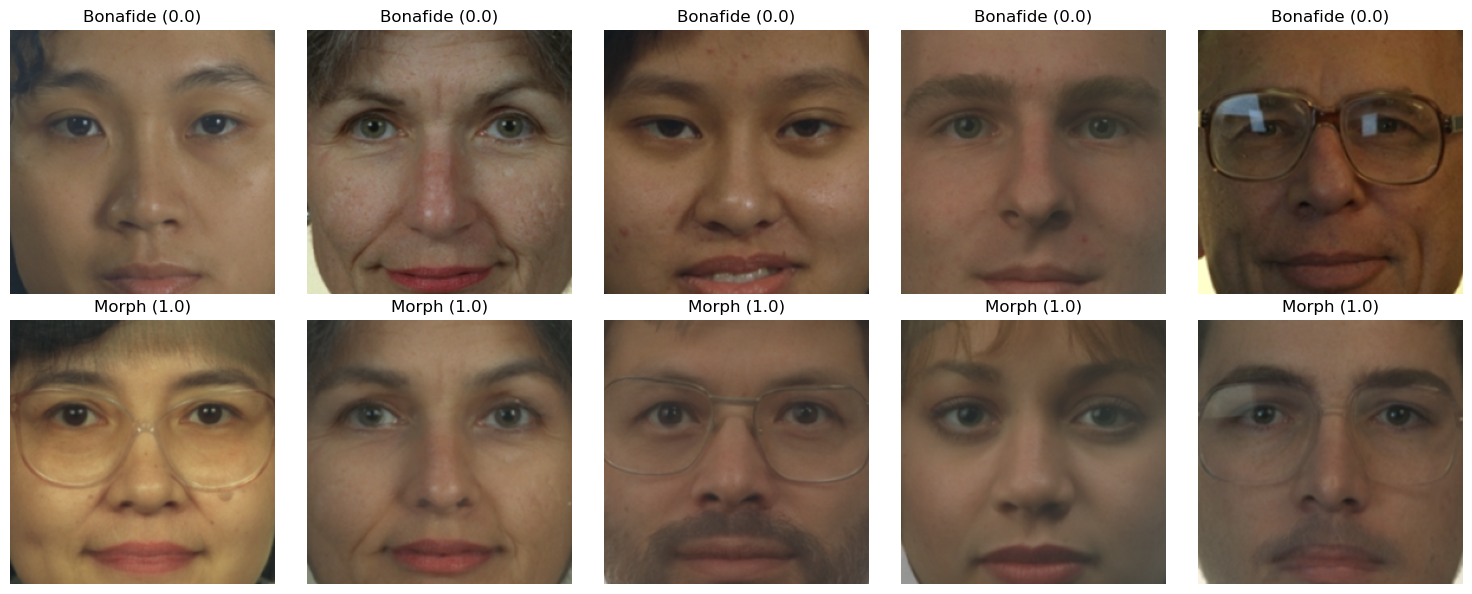

In [528]:
# Print some random examples of the data after using transform 
# Definiere die Anzahl der Bilder pro Label
num_images_per_label = 5

# Sammle die Bonafide- und Morph-Bilder aus dem Trainingsdataloader
bonafide_images = [(image, label) for image, label in train_dataloader.dataset if label == 0]
morph_images = [(image, label) for image, label in train_dataloader.dataset if label == 1]

# Wähle zufällig 5 Bonafide-Bilder
random_bonafide_images = random.sample(bonafide_images, k=num_images_per_label)

# Wähle zufällig 5 Morph-Bilder
random_morph_images = random.sample(morph_images, k=num_images_per_label)

# Erstelle eine Abbildung mit 2 Zeilen und num_images_per_label Spalten
fig, axes = plt.subplots(2, num_images_per_label, figsize=(15, 6))

# Zeige die zufälligen Bilder
for i, (image, label) in enumerate(random_bonafide_images + random_morph_images):
    row = i // num_images_per_label
    col = i % num_images_per_label

    axes[row, col].imshow(image.permute(1, 2, 0))  # Beachte die Reihenfolge der Achsen
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Bonafide ({label})" if row == 0 else f"Morph ({label})")

# Stelle sicher, dass alle Achsenbeschriftungen sichtbar sind
plt.tight_layout()

# Zeige die Abbildungcascade
#plt.savefig('examples.png')
plt.show()

In [529]:
# # Bilder aus dem Dataset anzeigen lassen 

# # Definiere die Anzahl der Bilder pro Label
# num_images_per_label = 5

# # Filtere die Bonafide- und Morph-Bilder aus dem Dataset
# bonafide_images = [(image, label) for image, label in dataset if label == 0]
# morph_images = [(image, label) for image, label in dataset if label == 1]

# # Wähle zufällig 5 Bonafide-Bilder
# random_bonafide_images = random.sample(bonafide_images, k=num_images_per_label)

# # Wähle zufällig 5 Morph-Bilder
# random_morph_images = random.sample(morph_images, k=num_images_per_label)

# # Erstelle eine Abbildung mit 2 Zeilen und num_images_per_label Spalten
# fig, axes = plt.subplots(2, num_images_per_label, figsize=(15, 6))

# # Zeige die zufälligen Bilder
# for i, (image, label) in enumerate(random_bonafide_images + random_morph_images):
#     row = i // num_images_per_label
#     col = i % num_images_per_label

#     # Ändere die Reihenfolge der Achsen
#     image = np.transpose(image, (1, 2, 0))

#     axes[row, col].imshow(image)
#     axes[row, col].axis('off')
#     axes[row, col].set_title("Bonafide" if label == 0 else "Morph")

# # Stelle sicher, dass alle Achsenbeschriftungen sichtbar sind
# plt.tight_layout()

# # Zeige die Abbildung
# plt.show()

In [530]:
# # Zufällige Auswahl von 5 Bildern aus dem Trainingsdataloader um die Struktur zu sehen.
# random_images = random.sample(train_dataloader.dataset, k=5)

# for images, labels in random_images:
#     # Ausgabe der Daten
#     print("Bild:")
#     print(images)
#     print("Label:")
#     print(labels)
#     print()

 ### 2 Self Trained CNN <a class="anchor" id="2"></a>
 #### 2.1 Model Class - Architecture <a class="anchor" id="2.1"></a>

In [95]:
import torch
import torch.nn as nn

class FaceMorphCNN(nn.Module):
    def __init__(self):
        super(FaceMorphCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        #print(x.size())
        x = self.conv_layers(x)
        x = self.flatten(x)
        #x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = FaceMorphCNN()


In [96]:
# Definieren Sie die Verlustfunktion und den Optimierer:
#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [97]:
def calculate_accuracy(outputs, labels):
    # Runden der Ausgaben auf Ganzzahlen
    predicted_labels = torch.round(outputs)
    
    # Vergleich der vorhergesagten Labels mit den tatsächlichen Labels
    correct_predictions = (predicted_labels == labels).sum().item()
    total_predictions = labels.size(0)
    
    # Berechnung der Genauigkeit
    accuracy = correct_predictions / total_predictions
    
    return accuracy

#### 2.2 Train Model  <a class="anchor" id="2.2"></a>

In [98]:
accuracy_values = []
train_losses = []
val_losses = []
best_val_accuracy = 0.0

num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    # Trainingsschleife
    model.train()
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)  
        
        # Vorwärtsdurchlauf
        outputs = model(images)
        
        # Runden der Ausgaben auf Ganzzahlen
        outputs = torch.round(outputs)
        
        # Zielvariablen auf die richtige Größe erweitern
        #labels = labels.squeeze(dim=1).long()
        labels = labels.unsqueeze(1)
        
        # Berechnung des Losses
        loss = criterion(outputs, labels)
        
        # Rückwärtsdurchlauf und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        # Verlustwert hinzufügen
        running_loss += loss.item()
        
        # Genauigkeit berechnen
        accuracy = calculate_accuracy(outputs, labels)
        correct_predictions += (accuracy * labels.size(0))
        total_predictions += labels.size(0)
        
    # Durchschnittlichen Verlust berechnen
    epoch_loss = running_loss / len(train_dataloader)
    
    # Genauigkeit berechnen
    epoch_accuracy = correct_predictions / total_predictions
    
    #Genauigkeit berechnen und zur Liste hinzufügen
    #accuracy = calculate_accuracy(outputs, labels)
    accuracy_values.append(epoch_accuracy)
    
    # Verlust und Genauigkeit zur Liste hinzufügen
    train_losses.append(epoch_loss)
    #train_accuracies.append(epoch_accuracy)
    
   # Ausgabe für Training
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}")
    

    # Validierungsschleife
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            # Vorwärtsdurchlauf für Validierung
            val_outputs = model(val_images)
            val_outputs = torch.round(val_outputs)
            
            val_labels = val_labels.unsqueeze(1).to(device)
            
            # Verlust für Validierung berechnen
            val_loss += criterion(val_outputs, val_labels).item()
            
            # Genauigkeit für Validierung berechnen
            val_accuracy = calculate_accuracy(val_outputs, val_labels)
            val_correct_predictions += (val_accuracy * val_labels.size(0))
            val_total_predictions += val_labels.size(0)
    
    # Durchschnittlichen Verlust und Genauigkeit für die Validierung berechnen
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_accuracy = val_correct_predictions / val_total_predictions
    
    # Verlust und Genauigkeit für die Validierung zur Liste hinzufügen
    val_losses.append(val_epoch_loss)
    
    # Ausgabe für Validierung
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")
    
    # Überprüfen, ob die aktuelle Validierungsgenauigkeit besser ist als die bisher beste Genauigkeit
    if val_epoch_accuracy > best_val_accuracy:
        best_val_accuracy = val_epoch_accuracy
        # Beste Parameter des Modells speichern
        torch.save(model.state_dict(), "best_model_self_trained.pth")

# Modell mit den besten Parametern laden
model.load_state_dict(torch.load("best_model_self_trained.pth"))

# Testschleife
model.eval()
test_correct_predictions = 0
test_total_predictions = 0

with torch.no_grad():
    for test_images, test_labels in test_dataloader:
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)
        
        # Vorwärtsdurchlauf für Testdaten
        test_outputs = model(test_images)
        test_outputs = torch.round(test_outputs)
        
        # Genauigkeit für Testdaten berechnen
        test_accuracy = calculate_accuracy(test_outputs, test_labels)
        test_correct_predictions += (test_accuracy * test_labels.size(0))
        test_total_predictions += test_labels.size(0)

# Genauigkeit für Testdaten berechnen
test_epoch_accuracy = test_correct_predictions / test_total_predictions

# Ausgabe für Testdaten
print(f"Test Accuracy: {test_epoch_accuracy:.4f}")



Epoch [1/10], Training Loss: 56.2500, Training Accuracy: 0.4583
Epoch [1/10], Validation Loss: 37.5000, Validation Accuracy: 0.6250
Epoch [2/10], Training Loss: 53.1250, Training Accuracy: 0.4583
Epoch [2/10], Validation Loss: 37.5000, Validation Accuracy: 0.6250
Epoch [3/10], Training Loss: 56.2500, Training Accuracy: 0.4583
Epoch [3/10], Validation Loss: 37.5000, Validation Accuracy: 0.6250
Epoch [4/10], Training Loss: 53.1250, Training Accuracy: 0.4583
Epoch [4/10], Validation Loss: 37.5000, Validation Accuracy: 0.6250
Epoch [5/10], Training Loss: 56.2500, Training Accuracy: 0.4583
Epoch [5/10], Validation Loss: 37.5000, Validation Accuracy: 0.6250
Epoch [6/10], Training Loss: 59.3750, Training Accuracy: 0.4583
Epoch [6/10], Validation Loss: 37.5000, Validation Accuracy: 0.6250
Epoch [7/10], Training Loss: 59.3750, Training Accuracy: 0.4583
Epoch [7/10], Validation Loss: 37.5000, Validation Accuracy: 0.6250
Epoch [8/10], Training Loss: 46.8750, Training Accuracy: 0.4583
Epoch [8/10]

In [99]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
          Flatten-10                [-1, 50176]               0
           Linear-11                  [-1, 128]       6,422,656
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

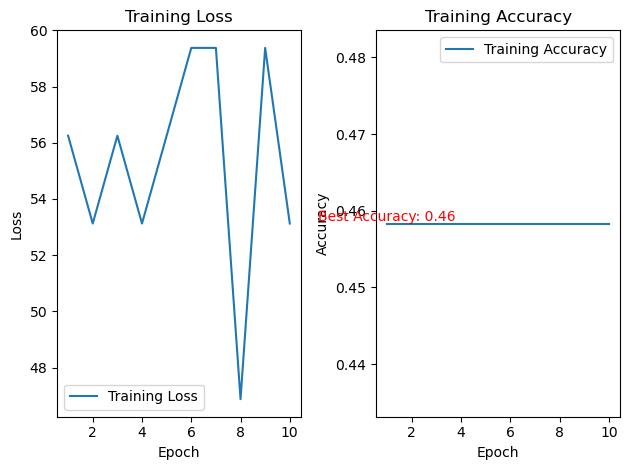

In [101]:
# Verlustkurve plotten
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Genauigkeitskurve plotten
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), accuracy_values, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

# Best Accuracy ermitteln
best_accuracy = max(accuracy_values)
best_epoch = accuracy_values.index(best_accuracy) + 1

# Anzeige der Best Accuracy
plt.text(best_epoch, best_accuracy, f'Best Accuracy: {best_accuracy:.2f}', ha='center', va='bottom', color='red')


# Anzeige der Plots
plt.tight_layout()
#plt.savefig('loss_accuracz_self_cnn?50.png')
plt.show()


#### 2.3 Evaluate Model  <a class="anchor" id="2.3"></a>

In [100]:
# Funktion zum Plotten der Verteilung der Ergebnisse
def plot_result_distribution(results):
    # Zählen der Anzahl von Bonafide- und Morph-Ergebnissen
    bonafide_count = sum(result == 0 for result in results)
    morph_count = sum(result == 1 for result in results)

    # Erstellen des Balkendiagramms
    labels = ['Bonafide', 'Morph']
    counts = [bonafide_count, morph_count]

    plt.bar(labels, counts)
    plt.xlabel('Klasse')
    plt.ylabel('Anzahl')
    plt.title('Verteilung der Ergebnisse')
    plt.show()

# Ergebnisse für den Trainingsdatensatz berechnen
train_results = []
model.eval()  # Setzen des Modells in den Evaluationsmodus

with torch.no_grad():
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predictions = torch.round(outputs).squeeze().tolist()
        results = [pred == label.item() for pred, label in zip(predictions, labels)]
        train_results.extend(results)

# Plotten der Verteilung der Ergebnisse
#plot_result_distribution(train_results)

# Ausgabe der Anzahl der Klassifikationen
bonafide_count = sum(result == 0 for result in train_results)
morph_count = sum(result == 1 for result in train_results)

print("Anzahl der Bonafide-Klassifikationen:", bonafide_count)
print("Anzahl der Morph-Klassifikationen:", morph_count)


Anzahl der Bonafide-Klassifikationen: 39
Anzahl der Morph-Klassifikationen: 33


In [774]:
#print(model.state_dict().keys())
#print(model.state_dict()['conv_layers.0.weight'].size())

In [485]:
# Wahrscheinlichkeiten für die positive Klasse berechnen
probs = []
labels = []

# Testdaten durchlaufen und Wahrscheinlichkeiten und Labels sammeln
for images, target in test_dataloader:
    images = images.to(device)
    target = target.to(device)
    
    # Vorhersagen für die Batch-Daten erhalten
    outputs = model(images)
    probabilities = (outputs > 0.5).int()
    
    # Wahrscheinlichkeiten und Labels zu den Listen hinzufügen
    probs.extend(probabilities)  # Wahrscheinlichkeit der positiven Klasse
    labels.extend(target.cpu().numpy())

# Berechnen Sie die False Positive Rate und die True Positive Rate
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)

In [486]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Funktion zum Plotten der Verteilung der Vorhersagen
def plot_prediction_distribution(predictions):
    # Zählen der Anzahl von Bonafide- und Morph-Vorhersagen
    bonafide_count = sum(pred == 0 for pred in predictions)
    morph_count = sum(pred == 1 for pred in predictions)

    # Erstellen des Balkendiagramms
    labels = ['Bonafide', 'Morph']
    counts = [bonafide_count, morph_count]

    plt.bar(labels, counts)
    plt.xlabel('Klasse')
    plt.ylabel('Anzahl')
    plt.title('Verteilung der Vorhersagen')
    plt.show()

# Vorhersagen für den Testdatensatz berechnen
test_predictions = []
y_test_labels = []
test_accuracy_list = []
model.eval()  # Setzen des Modells in den Evaluationsmodus

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        #labels = torch.tensor(labels).to(device)
        labels = labels.to(device)
        #labels = torch.tensor([0 if "bonafide" in label else 1 for label in labels]).to(device)

        outputs = model(images)
        predictions = torch.round(outputs).squeeze().tolist()
        
        # Anzahl der korrekten Vorhersagen zählen
        correct += (torch.round(outputs) == labels).sum().item()
        total += labels.size(0)
        
        # Testgenauigkeit berechnen und speichern
        test_accuracy = correct / total
        test_accuracy_list.append(test_accuracy)
        
        y_test_labels.extend(labels.tolist())
        test_predictions.extend(predictions)

# Plotten der Verteilung der Vorhersagen
#plot_prediction_distribution(test_predictions)

# Ausgabe der Anzahl der Klassifikationen
bonafide_count_test = sum(result == 0 for result in test_predictions)
morph_count_test = sum(result == 1 for result in test_predictions)

print("Anzahl der Bonafide-Klassifikationen:", bonafide_count_test)
print("Anzahl der Morph-Klassifikationen:", morph_count_test)
# Testgenauigkeit ausgeben
print("Test Accuracy:", test_accuracy)

# Umwandeln der Listen in Numpy-Arrays
y_test_labels = np.array(y_test_labels)
test_predictions = np.array(test_predictions)

# Konfusionsmatrix berechnen
y_test_labels = torch.tensor(y_test_labels).to(device)  # Konvertierung in Tensor
test_predictions = torch.tensor(test_predictions).to(device)  # Konvertierung in Tensor
confusion_mat = confusion_matrix(y_test_labels, test_predictions)

# Plot der Konfusionsmatrix
#sns.heatmap(confusion_mat/np.sum(confusion_mat), annot=True, fmt='.2%', cmap='Blues')
#plt.xlabel('Vorhersage')
#plt.ylabel('Wahre Klasse')
#plt.title('Konfusionsmatrix')
#plt.show()


Anzahl der Bonafide-Klassifikationen: 20
Anzahl der Morph-Klassifikationen: 0
Test Accuracy: 12.0


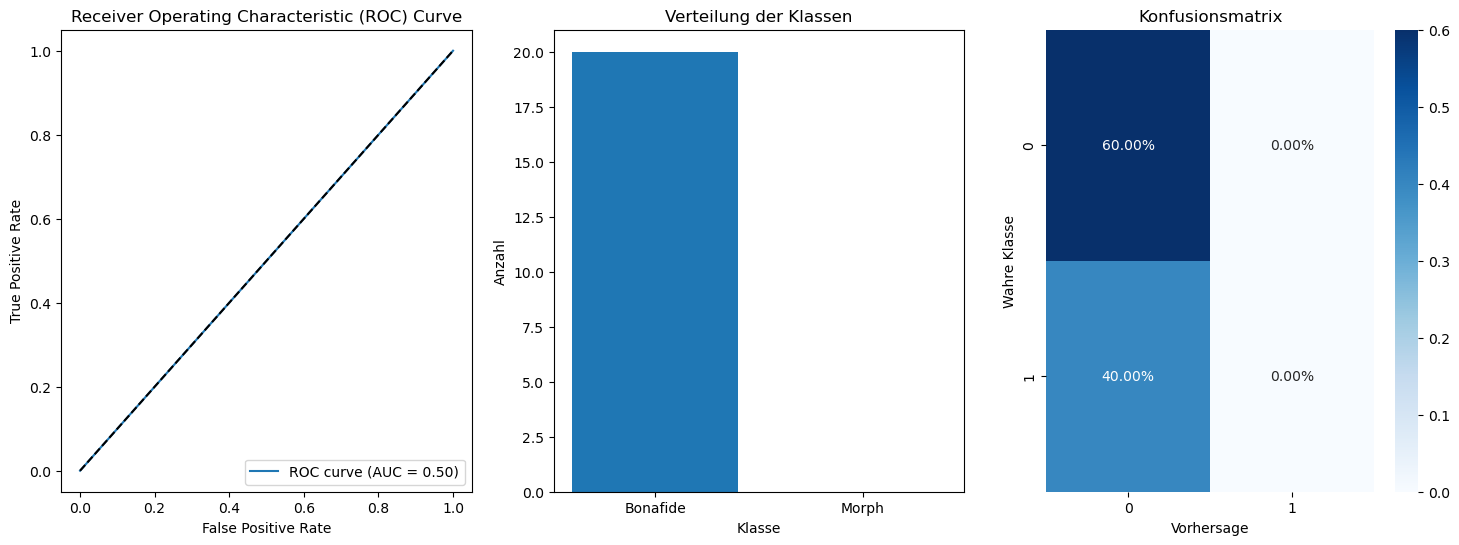

<Figure size 640x480 with 0 Axes>

In [487]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
# Plot der ROC-Kurve und AUC
axes[0].plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[0].legend(loc='lower right')

# Plot der Histogramme der Klassenverteilung
# Zählen der Anzahl von Bonafide- und Morph-Vorhersagen
bonafide_count = sum(pred == 0 for pred in predictions)
morph_count = sum(pred == 1 for pred in predictions)
labels = ['Bonafide', 'Morph']
counts = [bonafide_count, morph_count]
axes[1].bar(labels, counts)
axes[1].set_xlabel('Klasse')
axes[1].set_ylabel('Anzahl')
axes[1].set_title('Verteilung der Klassen')

# Plot der Konfusionsmatrix
sns.heatmap(confusion_mat/np.sum(confusion_mat), annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Vorhersage')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()

# Anpassen des Layouts und Anzeigen der Plots
plt.tight_layout()
#plt.savefig('self_cnn_test_metrik?50-CASCADE.png')
plt.show()


### 3 Transfer Learning <a class="anchor" id="3"></a>

#### 3.1 Load Model <a class="anchor" id="3.1"></a> 

In [531]:
#tranfer learning 
import torchvision.models as models
# Schritt 1: Lade das vortrainierte VGG16-Modell
vggface = models.vgg16(pretrained=True)

/opt/homebrew/anaconda3/envs/biometrics/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/biometrics/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [536]:
def calculate_accuracy(outputs, labels):
    # Runden der Ausgaben auf Ganzzahlen
    predicted_labels = torch.round(outputs)
    
    # Vergleich der vorhergesagten Labels mit den tatsächlichen Labels
    correct_predictions = (predicted_labels == labels).sum().item()
    total_predictions = labels.size(0)
    
    # Berechnung der Genauigkeit
    accuracy = correct_predictions / total_predictions
    
    return accuracy

#### 3.2 Freeze Weights <a class="anchor" id="3.2"></a> 

In [532]:
# Schritt 2: Einfriere die Gewichte des vortrainierten Modells
for param in vggface.parameters():
    param.requires_grad = False

#### 3.3 Fine Tuning <a class="anchor" id="3.3"></a> 

In [533]:
# Schritt 3: Passe die letzte Fully Connected-Schicht an deine Aufgabe an
num_features = vggface.classifier[6].in_features
classifier = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 1),
    nn.Sigmoid()  # Sigmoid-Aktivierungsfunktion für binäre Klassifikation
)
vggface.classifier[6] = classifier

#### 3.4 Train Transfer Learning Model <a class="anchor" id="3.4"></a> 

In [534]:
#Schritt 4 Definiere Verlustfunktion und den Optimierungsalgorithmus:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(vggface.parameters(), lr=0.001)

In [537]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vggface.to(device)

accuracy_values = []
val_accuracy_values = []
train_losses = []
num_epochs = 20

for epoch in range(num_epochs):
    vggface.train()

    running_loss = 0.0
    # Trainingsgenauigkeit berechnen
    correct_predictions = 0
    total_predictions = 0
    
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Vorwärtsdurchlauf
        outputs = vggface(images)
        
        labels = labels.unsqueeze(1).float()
        
        # Berechnung des Losses
        loss = criterion(outputs, labels)
        
        # Rückwärtsdurchlauf und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Verlustwert hinzufügen
        running_loss += loss.item()
        
        # Genauigkeit berechnen
        accuracy = calculate_accuracy(outputs, labels)
        correct_predictions += accuracy * labels.size(0)
        total_predictions += labels.size(0)
        
    # Durchschnittlichen Verlust berechnen
    epoch_loss = running_loss / len(train_dataloader)
    
    # Genauigkeit berechnen
    epoch_accuracy = correct_predictions / total_predictions
    
    # Verlust und Genauigkeit zur Liste hinzufügen
    train_losses.append(epoch_loss)
    accuracy_values.append(epoch_accuracy)
    
    # Validierungsgenauigkeit berechnen
    vggface.eval()
    val_correct_predictions = 0
    val_total_predictions = 0
    
    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            val_outputs = vggface(val_images)
            val_labels = val_labels.unsqueeze(1).float()
            
            val_accuracy = calculate_accuracy(val_outputs, val_labels)
            val_correct_predictions += val_accuracy * val_labels.size(0)
            val_total_predictions += val_labels.size(0)
    
    # Validierungsgenauigkeit berechnen und speichern
    val_epoch_accuracy = val_correct_predictions / val_total_predictions
    val_accuracy_values.append(val_epoch_accuracy)
        
    # Testgenauigkeit berechnen
    vggface.eval()
    test_correct_predictions = 0
    test_total_predictions = 0
    
    with torch.no_grad():
        for test_images, test_labels in test_dataloader:
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)
            
            test_outputs = vggface(test_images)
            test_labels = test_labels.unsqueeze(1).float()
            
            test_accuracy = calculate_accuracy(test_outputs, test_labels)
            test_correct_predictions += test_accuracy * test_labels.size(0)
            test_total_predictions += test_labels.size(0)
    
    # Testgenauigkeit berechnen und speichern
    test_epoch_accuracy = test_correct_predictions / test_total_predictions
    test_accuracy_values.append(test_epoch_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}, Test Accuracy: {test_epoch_accuracy:.4f}")

Epoch [1/20], Loss: 0.7037, Train Accuracy: 0.6625, Val Accuracy: 0.8875, Test Accuracy: 0.8300
Epoch [2/20], Loss: 0.4894, Train Accuracy: 0.7611, Val Accuracy: 0.9000, Test Accuracy: 0.8750
Epoch [3/20], Loss: 0.4457, Train Accuracy: 0.7889, Val Accuracy: 0.8625, Test Accuracy: 0.8250
Epoch [4/20], Loss: 0.4164, Train Accuracy: 0.8125, Val Accuracy: 0.8750, Test Accuracy: 0.8900
Epoch [5/20], Loss: 0.4050, Train Accuracy: 0.8417, Val Accuracy: 0.8875, Test Accuracy: 0.8700
Epoch [6/20], Loss: 0.3951, Train Accuracy: 0.8264, Val Accuracy: 0.6875, Test Accuracy: 0.6600
Epoch [7/20], Loss: 0.3852, Train Accuracy: 0.8389, Val Accuracy: 0.8875, Test Accuracy: 0.8950
Epoch [8/20], Loss: 0.4130, Train Accuracy: 0.8250, Val Accuracy: 0.9125, Test Accuracy: 0.8800
Epoch [9/20], Loss: 0.3754, Train Accuracy: 0.8333, Val Accuracy: 0.9250, Test Accuracy: 0.9200
Epoch [10/20], Loss: 0.3884, Train Accuracy: 0.8208, Val Accuracy: 0.9250, Test Accuracy: 0.9150
Epoch [11/20], Loss: 0.3889, Train Accu

In [538]:
summary(vggface, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

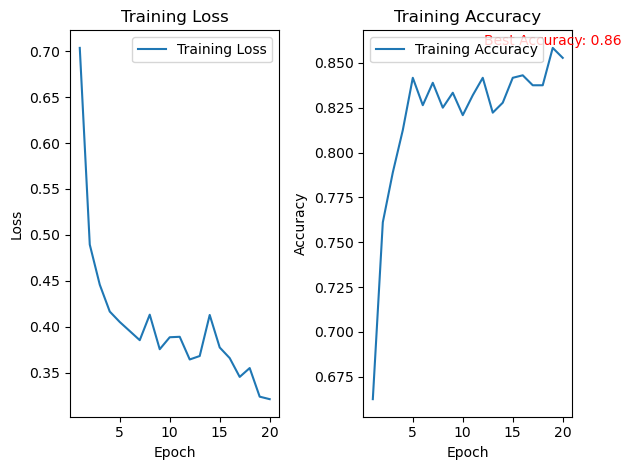

In [539]:
## Trainings Validierung

# Verlustkurve plotten
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Genauigkeitskurve plotten
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), accuracy_values, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

# Best Accuracy ermitteln
best_accuracy = max(accuracy_values)
best_epoch = accuracy_values.index(best_accuracy) + 1

# Anzeige der Best Accuracy
plt.text(best_epoch, best_accuracy, f'Best Accuracy: {best_accuracy:.2f}', ha='center', va='bottom', color='red')


# Anzeige der Plots
plt.tight_layout()
plt.savefig('transfer_50_training_loss_accuracy3_cascade_4_07.png')
plt.show()



##### 3.4.1 Train, Validation & Test Accuracy <a class="anchor" id="3.4.1"></a> 

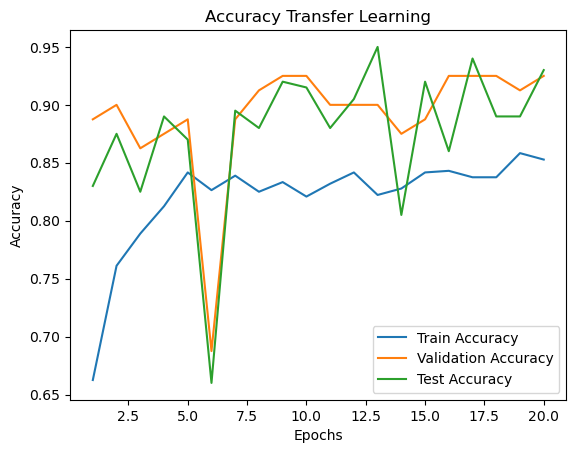

In [546]:
# Plotten der Genauigkeiten
plt.plot(range(1, num_epochs + 1), accuracy_values, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy_values, label='Validation Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracy_values, label='Test Accuracy')

# Beschriftungen und Legende hinzufügen
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Transfer Learning')
plt.legend()

# Anzeige des Plots
plt.savefig('transfer_50_training_val__test_accuracy2_cascade_04_07.png')
plt.show()


#### 3.5 Evaluate Transfer Learning Model <a class="anchor" id="3.5"></a> 

In [547]:
# define some useful PAD evaluation functions 

def calculate_metrics(test_labels, predictions):
    fpr, tpr, thresholds = roc_curve(test_labels, predictions)
    auc_score = auc(fpr, tpr)
    far = fpr
    frr = 1 - tpr
    eer = fpr[np.nanargmin(np.abs((fpr + frr - 1)))]
   
    return fpr, tpr, thresholds, eer, auc_score, far, frr

def calculate_APCER(test_labels, predictions):
    # Berechnung der Attack Presentation Classification Error Rate (APCER)
    apcer = (np.sum((test_labels == 0) & (predictions == 1)) / np.sum(test_labels == 0)) * 100
    return apcer

def calculate_BPCER(test_labels, predictions):
    # Berechnung der Bona fide Presentation Classification Error Rate (BPCER)
    bpcer = (np.sum((test_labels == 1) & (predictions == 0)) / np.sum(test_labels == 1)) * 100
    return bpcer

def evaluate_model(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    predictions = []
    probabilities = []
    test_labels = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted_labels = (outputs > 0.5).int()

            probabilities.extend(outputs)
            predictions.extend(predicted_labels)
            test_labels.extend(labels)

    test_labels = np.array(test_labels)
    predictions = np.array(predictions)
    probabilities = np.array(probabilities)
    
    fpr, tpr, thresholds = roc_curve(test_labels, predictions)
    roc_auc = auc(fpr, tpr)
    
    apcer = calculate_APCER(test_labels, predictions)
    bpcer = calculate_BPCER(test_labels, predictions)

    # Restlicher Code für die Auswertung der Metriken und Plots

    # Plot der ROC-Kurve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Plot von FAR und FRR zur Bestimmung des besten Thresholds
    far = fpr
    frr = 1 - tpr
    eer_threshold_idx = np.nanargmin(np.abs((far + frr - 1)))
    best_threshold = thresholds[eer_threshold_idx]

    plt.figure()
    plt.plot(thresholds, far, label='FAR')
    plt.plot(thresholds, frr, label='FRR')
    plt.plot([best_threshold, best_threshold], [0, 1], 'r--', label='Best Threshold: %.2f' % best_threshold)
    plt.xlabel('Threshold')
    plt.ylabel('Error Rate')
    plt.title('FAR & FRR')
    plt.legend()
    plt.show()

    return apcer, bpcer, roc_auc, best_threshold


##### 3.5.1 ROC Plot <a class="anchor" id="3.5.1"></a> 

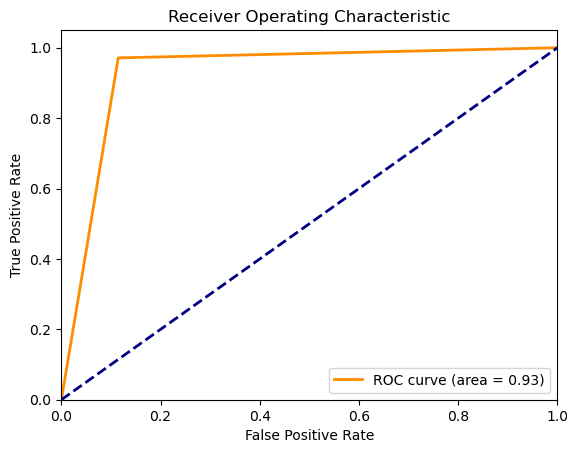

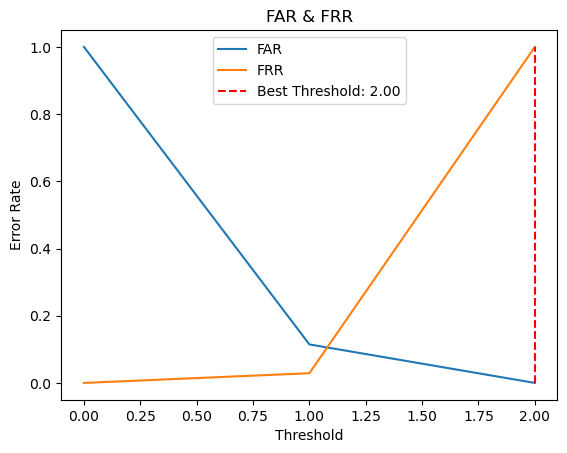

APCER: 11200.00
BPCER: 8800.00
ROC AUC: 0.93
Best Threshold: 2.00


In [548]:
# Plot ROC Curve and FAR & FRR comparison
apcer, bpcer, roc_auc, best_threshold = evaluate_model(vggface, test_dataloader)

print("APCER: %.2f" % apcer)
print("BPCER: %.2f" % bpcer)
print("ROC AUC: %.2f" % roc_auc)
print("Best Threshold: %.2f" % best_threshold)

In [637]:
# create test model funciton
def test_model(model, dataloader):
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    predictions = []
    probabilities = []
    test_labels = []

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = (outputs > 0.5).int()
            predictions.extend(predicted.flatten().tolist())
            #predictions = [item for sublist in predictions for item in sublist]
            probabilities.extend(outputs.tolist())
            test_labels.extend(labels.int().tolist())
            
            total_predictions += labels.size(0)
            
        for pred, label in zip(predictions, test_labels):
            if pred == label:
                correct_predictions += 1        

    accuracy = correct_predictions / total_predictions

    return predictions, probabilities, test_labels, accuracy



In [638]:
predictions, probabilities, labels, accuracy = test_model(vggface, test_dataloader)

##### 3.5.2 Test Accuracy <a class="anchor" id="3.5.2"></a> 

In [640]:
# Ausgabe der Testgenauigkeit und Metriken
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9300


##### 3.5.3 Confusion Matrix and Performance Metrics <a class="anchor" id="3.5.3"></a> 

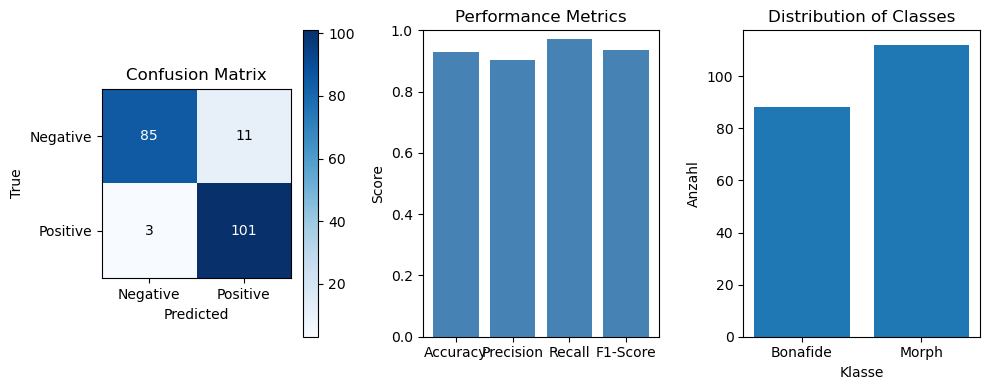

In [641]:
# Metriken visualisieren
def plot_performance_metrics(test_labels, test_predictions):
    # Berechnung der Metriken
    accuracy = accuracy_score(test_labels, test_predictions)
    precision = precision_score(test_labels, test_predictions, average='binary',zero_division=1)
    recall = recall_score(test_labels, test_predictions, average='binary')
    f1 = f1_score(test_labels, test_predictions, average='binary')
    confusion = confusion_matrix(test_labels, test_predictions)

    # Visualisierung der Metriken
    labels = ['Negative', 'Positive']

    # Confusion Matrix
    plt.figure(figsize=(10, 4))
    plt.subplot(131)
    plt.imshow(confusion, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks(np.arange(len(labels)), labels)
    plt.yticks(np.arange(len(labels)), labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, confusion[i, j], ha='center', va='center', color='white' if confusion[i, j] > confusion.max() / 2 else 'black')

    # Metriken als Bar-Plot
    plt.subplot(132)
    metrics = [accuracy, precision, recall, f1]
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    plt.bar(metric_labels, metrics, color='steelblue')
    plt.ylim([0, 1])
    plt.ylabel('Score')
    plt.title('Performance Metrics')
    
    # Histogramm der Klassenverteilung
    plt.subplot(133)
    bonafide_count = sum(pred == 0 for pred in predictions)
    morph_count = sum(pred == 1 for pred in predictions)
    class_labels = ['Bonafide', 'Morph']
    class_counts = [bonafide_count, morph_count]
    plt.bar(class_labels, class_counts)
    plt.xlabel('Klasse')
    plt.ylabel('Anzahl')
    plt.title('Distribution of Classes')
    plt.tight_layout()
    
    #plt.savefig('transfer_50_PAD2_2_cascade.png')
    plt.show()

    
plot_performance_metrics(labels, predictions)

plt.show()

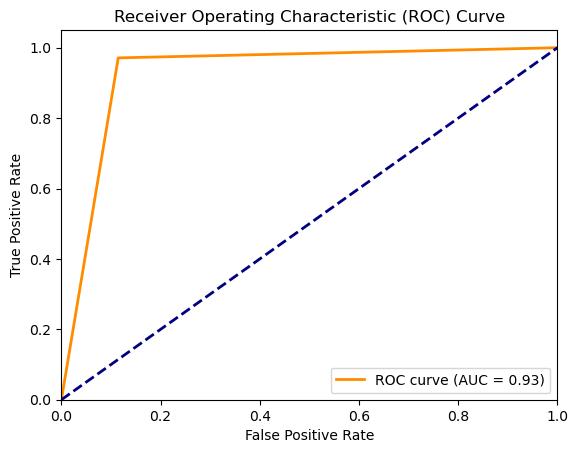

In [570]:
def plot_ROC_curve(labels, predictions):
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('ROC_curve.png')
    plt.show()
    
plot_ROC_curve(labels, predictions)


##### 3.5.4 DET Curve <a class="anchor" id="3.5.4"></a> 

In [656]:
# plot DET curve
def calculate_bpcer_apcer(predictions, labels):
    bonafide_scores = []  # Liste der Vorhersagen für echte Benutzer
    moprh_scores = []  # Liste der Vorhersagen für betrügerische Angriffe

    for i in range(len(predictions)):
        if labels[i] == 0:  # Bonafide
            bonafide_scores.append(predictions[i])
        else:  # Moprh
            moprh_scores.append(predictions[i])

    # Berechnung der Schwellenwerte (Thresholds)
    thresholds = sorted(set(bonafide_scores + moprh_scores))

    bpcer = []  # Liste der BPCER-Werte
    apcer = []  # Liste der APCEER-Werte

    for threshold in thresholds:
        bonafide_accept = sum(score >= threshold for score in bonafide_scores) / len(bonafide_scores)
        moprh_accept = sum(score >= threshold for score in moprh_scores) / len(moprh_scores)

        bpcer.append(1 - bonafide_accept)  # BPCER = 1 - Genuine Acceptance Rate
        apcer.append(moprh_accept)  # APCER = moprh Acceptance Rate

    return bpcer, apceer

In [657]:
bpcer, apcer = calculate_bpcer_apcer(predictions,labels)

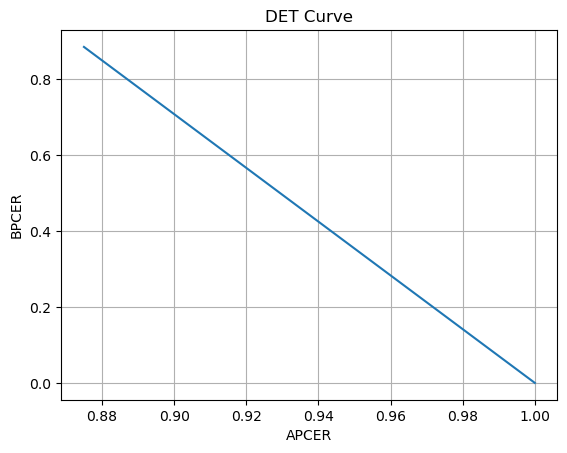

In [658]:
def plot_det_curve(bpcer, apcer):
    plt.plot(apcer, bpcer)
    plt.xlabel('APCER')
    plt.ylabel('BPCER')
    plt.title('DET Curve')
    plt.grid(True)
    plt.show()

# Annahme: bpcer und apcer sind Listen oder Arrays von Werten für verschiedene Schwellenwerte

plot_det_curve(bpcer, apcer)

### 4 Resume <a class="anchor" id="4"></a>

#### 4.1 Resume <a class="anchor" id="4.1"></a> 

##### ROC Curve:
The ROC curve is a graphical representation of the performance of a binary classifier. It illustrates the trade-off between the true positive rate (TPR) and the false positive rate (FPR).
The AUC, or Area Under the Curve, is a scalar value that quantifies the overall performance of the classification model represented by the ROC curve. It measures the area under the ROC curve.
The AUC can be interpreted as the probability that a positive instance will be ranked higher than a negative instance by the model. The higher the AUC, the better the model's ability to distinguish between positive and negative instances.

The AUC of 0.93 suggests that the model is performing at a high level and has a strong ability to distinguish between bonafide and morph samples. This indicates that the model is likely making accurate predictions and has a good overall performance

##### DET Curve:
DET is an alternative way to visualize performance of a binary classification system similar to the ROC curve. While the ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR), the DET curve plots the False Rejection Rate (FRR) against the False Acceptance Rate (FAR)

- False Rejection Rate (FRR): The proportion of genuine positive instances that are incorrectly classified as negatives, also known as the Miss Rate.
- False Acceptance Rate (FAR): The proportion of negative instances that are incorrectly classified as positives, also known as the False Alarm Rate.

In context of biometric Systmes the DET Curve is often used to plot the BPCER (Bonafide Presentation Classification Error Rate) on the y-axis and the APCER (Attack Presentation Classification Error Rate) on the x-axis.

The DET curve is a visualization that helps analyze and evaluate the trade-off between false rejection (BPCER) and false acceptance (APCER) rates of the biometric system

By plotting BPCER against APCER on the DET curve, one can assess the performance of the system in terms of its ability to distinguish between genuine and attack presentations. The goal is to find a balance that minimizes both BPCER and APCER, optimizing the system's accuracy and security.

As tht plotted DET curve is from the top left to the bottom right of the plot it suggests that the system is not able to distinguish between genuine and attack presentations effectively

A possible reason for the good overall accuracy is that the trainign set includes pictures which were used for moprhing so the model has post hoc information. 

#### 4.2 Furhter Work <a class="anchor" id="4.2"></a> 

- Test the model which was trained on one morphing techniques on different other moprhing techniques 
- Seperate morph images in validation and test set which corresponding bonafide samples are in training set